# Homework 3 (10 points)
This homework will make use of pandas dataframese to extract and manipulate metadata of seismic station in the Northern California Seismic Network. The learning objective are: data download from URL, dataframes with pandas, basic data manipulation. Use the tutorials shown in class and the pandas resources (https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)

### Think like a researcher:

We want to download seismic waveforms from a seismic data archive of specific earthquakes. We am not sure what sensors (seismometers) is operating at that time. The list of stations available in the seismic networkhas more than 6000, that's way too many! So we want to filter only the seismic stations that are relevant for the research.

In [1]:
# Address of the website to download data
url = 'http://ncedc.org/ftp/pub/doc/NC.info/NC.channel.summary.day'

In [2]:
# Useful Python modules
import numpy as np
import pandas as pd
import io
import pickle
import requests
from datetime import datetime, timedelta
from math import cos, sin, pi, sqrt

In [3]:
# Import the data from the website into a Python dataframe
s = requests.get(url).content
data = pd.read_csv(io.StringIO(s.decode('utf-8')), header=None, skiprows=2, sep='\s+', usecols=list(range(0, 13)))
data.columns = ['station', 'network', 'channel', 'location', 'rate', 'start_time', 'end_time', 'latitude', 'longitude', 'elevation', 'depth', 'dip', 'azimuth']

In [4]:
# Transform columns start_time and end_time into datetime format
startdate = pd.to_datetime(data['start_time'], format='%Y/%m/%d,%H:%M:%S')
data['start_time'] = startdate
# Avoid 'OutOfBoundsDatetime' error with year 3000
enddate = data['end_time'].str.replace('3000', '2025')
enddate = pd.to_datetime(enddate, format='%Y/%m/%d,%H:%M:%S')
data['end_time'] = enddate

After discussing with my adviser, we decided than only the following channels are relevant for the work we want to do:

In [5]:
channels = ['BHE', 'BHN', 'BHZ', 'BH1', 'BH2', \
            'EHE', 'EHN', 'EHZ', 'EH1', 'EH2', \
            'HHE', 'HHN', 'HHZ', 'HH1', 'HH2', \
            'SHE', 'SHN', 'SHZ', 'SH1', 'SH2']

## Q1 (2 points)

Filter the dataset to keep only the rows with the channels as defined above. 

In [6]:
data =data.loc[data.channel.isin(channels)]
data.reset_index(inplace=True)

## Q2  (2 points)
My earthquake catalog starts on 2007/07/01 and ends on 2009/07/01. I am only interested in stations that started recording before 2007/07/01 and ended recording after 2009/07/01. The dataframe <code>data</code> has the start time and end times defined as <code>datetime</code> objects. That means that we can filter the dataframe columns by comparing the datetime objects. To create a datetime object

In [7]:
s1 = datetime(2007,7,1)
s2 = datetime(2009,7,1)
print(type(s1))
s1

<class 'datetime.datetime'>


datetime.datetime(2007, 7, 1, 0, 0)

Filter the dataset to keep only stations that started recording before 2007/07/01 and ended recording after 2009/07/01. 

In [8]:
data=data.loc[(data.start_time<s1) & (data.end_time>s2)]
data.reset_index(inplace=True)
data

,level_0,index,station,network,channel,location,rate,start_time,end_time,latitude,longitude,elevation,depth,dip,azimuth
0,4,4,AAS,NC,EHZ,--,100.0,1987-05-01 00:00:00,2025-01-01 00:00:00,38.43014,-121.10959,31.0,0.0,-90.0,0.0
1,8,8,ABJ,NC,EHZ,--,100.0,1992-11-10 20:00:00,2019-06-26 19:17:00,39.16577,-121.19299,434.0,0.0,-90.0,0.0
2,66,80,AOH,NC,EHZ,--,100.0,1987-05-01 00:00:00,2019-06-20 18:43:00,39.37627,-121.25767,410.0,0.0,-90.0,0.0
3,97,111,BAP,NC,SHZ,--,50.0,2004-01-22 22:00:00,2011-07-08 17:04:00,36.18042,-121.64440,1193.0,0.0,-90.0,0.0
4,102,116,BAV,NC,EHZ,--,100.0,2004-01-16 01:06:00,2020-06-01 18:40:00,36.64595,-121.03015,572.0,0.0,-90.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,2638,5983,PTQ,NC,SHZ,--,50.0,2003-05-06 22:00:00,2011-10-12 22:25:00,34.58187,-120.57398,448.0,0.0,-90.0,0.0
319,2645,5990,PTR,NC,SHZ,--,50.0,2003-05-06 22:00:00,2011-10-12 22:25:00,35.65415,-120.21332,594.0,0.0,-90.0,0.0
320,2647,6006,PVC,NC,EHZ,--,100.0,1987-05-01 00:00:00,2025-01-01 00:00:00,35.92207,-120.53499,770.0,0.0,-90.0,0.0
321,2655,6034,PWK,NC,EHZ,--,100.0,1990-01-18 23:55:00,2025-01-01 00:00:00,35.81450,-120.51195,470.0,0.0,-90.0,0.0


The cluster of these repeating earthquakes are located at latitude = 40.09N and longitude = -122.87E. Here is a function to compute the distance from the station to the earthquakes, and to add a column distance to the dataset

In [9]:
# the cluster of earthquakes is centered at the following location:
lat0 = 40.09000
lon0 = -122.87000

a = 6378.136 # radius of the Earth in km.
e = 0.006694470 # ellipticity


dx = (pi / 180.0) * a * cos(lat0 * pi / 180.0) / sqrt(1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0))
dy = (3.6 * pi / 648.0) * a * (1.0 - e * e) / ((1.0 - e * e * sin(lat0 * pi / 180.0) * sin(lat0 * pi / 180.0)) ** 1.5)
x = dx * (data['longitude'] - lon0)
y = dy * (data['latitude'] - lat0)

# calculate and fill in the dataframe with the new values
data['distance'] = np.sqrt(np.power(x, 2.0) + np.power(y, 2.0))

## Q3  (3 points)
We want to keep the stations that are located less than 100 km from my repeating earthquakes. For stations farther away, the signal-to-noise ratio would be too low. Filter the dataset to keep only stations that are within 100 km from the earthquakes.

In [10]:
data=data.loc[data.distance<100]

Finally, we want to group the result such that the final result looks organized like this:

|station|network|location|latitude|longitude |elevation|depth|distance |channel    |start_time         |end_time           |
|-------|-------|--------|--------|----------|---------|-----|---------|-----------|-------------------|-------------------|
|KBS 	|NC 	|-- 	 |39.91719|-123.59561|1120.0   |0.0  |64.720762|SHZ        |2002-10-17 00:00:00|2011-10-27 21:25:00|
|KCPB 	|NC 	|-- 	 |39.68631|-123.58242|1261.0   |0.0  |75.502041|HHZ,HHN,HHE|2006-10-18 00:08:00|2010-11-01 22:00:00|

We want one row per station, a against one row per channel. Use the pandas function <code>agg</code> to group the channels of a given station together, and srt with the earliest start date and the latest end date. Do not forget to reset the indices!
You can use the following function to group the channels together:

In [11]:
def f(x):
    """
    Concatenate channels
    """
    result = '%s' % ','.join(x)
    result = list(set(result.split(',')))
    result = '%s' % ','.join(result)
    return result

In [12]:
data_group= data.groupby(['station','network','location','latitude',
                          'longitude','elevation','depth','distance']).agg({'channel':lambda x: f(x),
                                                                            'start_time':lambda x: max(x),
                                                                            'end_time':lambda x: min(x)})

data_group.reset_index(inplace=True)
data_group

,station,network,location,latitude,longitude,elevation,depth,distance,channel,start_time,end_time
0,GBB,NC,--,39.80127,-122.34550,170.0,0.0,55.029997,EHZ,2000-12-06 18:38:00,2025-01-01 00:00:00
1,GCK,NC,--,39.54375,-122.43668,251.0,0.0,71.129241,EHZ,2000-06-06 21:58:00,2025-01-01 00:00:00
2,GFC,NC,--,39.32655,-122.28886,64.0,0.0,98.346307,EHZ,2001-04-03 23:25:00,2020-03-18 22:53:00
3,GHM,NC,--,39.49545,-122.93096,1456.0,0.0,66.387179,EHZ,1987-05-01 00:00:00,2025-01-01 00:00:00
4,GRO,NC,--,39.91684,-122.67117,1261.0,0.0,25.657089,EHZ,1990-12-13 23:30:00,2025-01-01 00:00:00
5,GTC,NC,--,39.39944,-123.55532,369.0,0.0,96.517590,SHZ,2002-10-17 00:00:00,2011-10-27 21:25:00
6,GTS,NC,--,39.31161,-122.60338,1069.0,0.0,89.574233,EHZ,1987-05-01 00:00:00,2020-10-19 16:57:00
7,KBN,NC,--,39.89237,-123.19503,1329.0,0.0,35.358386,SHZ,2002-10-17 00:00:00,2011-10-27 21:25:00
8,KBS,NC,--,39.91719,-123.59561,1120.0,0.0,64.720762,SHZ,2002-10-17 00:00:00,2011-10-27 21:25:00
9,KCR,NC,--,40.42644,-123.82064,873.0,0.0,89.203098,SHZ,2002-08-29 00:00:00,2011-11-01 17:05:00


## Q4  (3 points)

How many stations are left in the dataset? Can you plot them using a mapping toolbox or matplotlib? Please add  axis labels, update the fontsize to 14 points, add a title, and a legend, save the file as a PNG.

In [13]:
print("Number of stations:",len(data))

Number of stations: 26


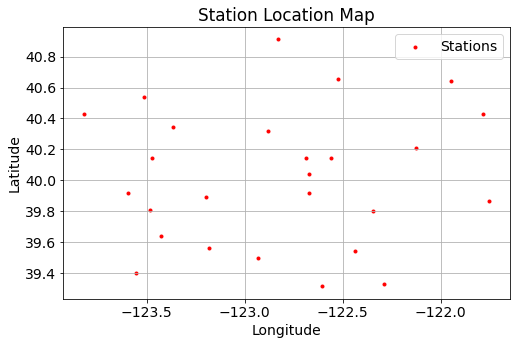

In [14]:
import matplotlib.pyplot as plt
params = {'legend.fontsize': 14, \
          'xtick.labelsize':14, \
          'ytick.labelsize':14, \
          'font.size':14}

plt.rcParams.update(params)

fig, ax1 = plt.subplots(figsize=(8.0, 5.0))
fig.patch.set_facecolor('white')
ax1.scatter(data_group['longitude'],data_group['latitude'],label = 'Stations',marker = '.',color='red')
ax1.set_title('Station Location Map')
ax1.legend()
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid()
plt.savefig('Kidiwela_ESS590_fig_hw3.png')